In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo
from scipy import signal

def wave(t,*pars):
    amp,t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*amp*(np.exp(-(t-t0).astype(float)/tau1)-np.exp(-(t-t0).astype(float)/tau2))

fac=1
pretrigger=700

def linearCombine(a1,b1,off):# (N,*pars):
    N=pretrigger
    t=np.arange(N,dtype=float)
    v=np.zeros((7,N),dtype=float) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*fac*t)
    v[1,0:N]=b1*np.cos(w*fac*t)
    v[2,0:N]=off
    #v[2,0:N]=a2*np.sin(w/2.*t)
    #v[3,0:N]=b2*np.cos(w/2.*t)
    #v[4,0:N]=c*wave(t,1,t0,tau,rise)
    return np.sum(v,axis=0)
means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])
means=np.ones(48,dtype='float')*1250
run='/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin'
run='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/Run_0_0.bin'
numwaves=int((os.stat(run).st_size-8)/7033)
print(numwaves)
data=fr.raw(run,length=3500,row=1000,numwaves=10000)
wo.baseline_restore(data,600)

100000


Amplitude        +/- Standard Dev 
 ---------------------------------------
19.013038883621903 +/- 262.4351250636104
-303.04344536284236 +/- 262.4351250636104
306.0454285714286 +/- 185.56965655401862

Covariance Matrix 
 ------------------------
[[ 1.97182769e+01 -1.36103733e-15 -2.00152549e-16]
 [-1.36103733e-15  1.97182769e+01  1.60122039e-16]
 [-2.00152549e-16  1.60122039e-16  9.85913847e+00]]

 X^2/DoF               Sigma        
 ----------------------------
34506.98463916373 | 185.7605572751216

Correlation Matrix 
 ------------------------
[[ 1.00000000e+00 -6.90241515e-17 -1.43551311e-17]
 [-6.90241515e-17  1.00000000e+00  1.14841048e-17]
 [-1.43551311e-17  1.14841048e-17  1.00000000e+00]]


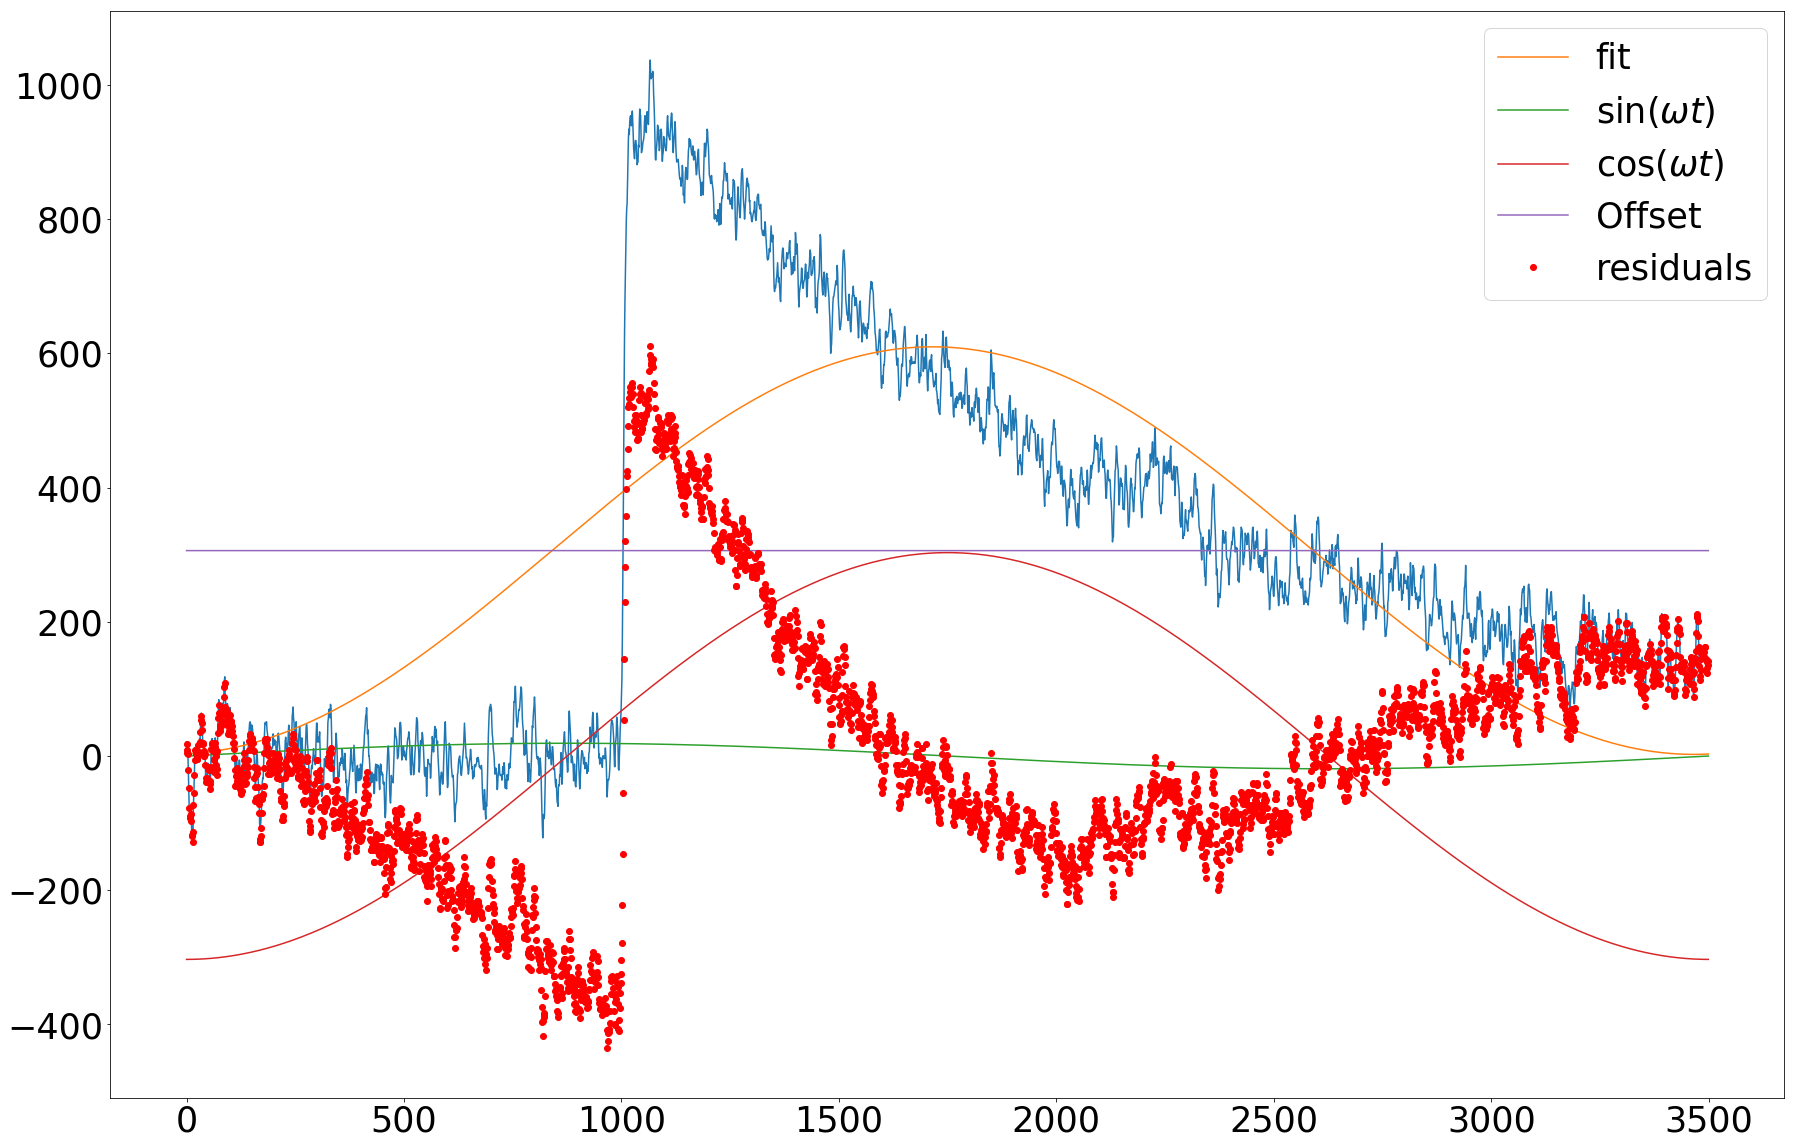

In [20]:
fs=35
bd,ch=1,3
length=3500
rise,top=20,1
length=len(data['wave'][0])
amps=np.zeros((len(data),4))
DesignT=np.array([linearCombine(1,0,0), \
                   linearCombine(0,1,0), \
                   linearCombine(0,0,1)])
t=np.arange(length)
shorttraps=np.zeros((48,length))
wo.multi_trap(arr=shorttraps,rise=20,top=1)
out=np.zeros(length)
p=np.zeros(3)
N=5
#data=pd.single_pixel(data,bd,ch)
for i in range(N,N+1,1):
#    bdch=data['board'][i]*8+data['channel'][i]
#    out =signal.fftconvolve(data['wave'][i],shorttraps[bdch], \
#                            'full')[0:length]/float(rise*means[bdch])
#    loc = np.argmax(out)-rise
#    mx  = data['wave'][i,loc+10]
#    DesignT[2,0:length]= wave(t,1,loc,means[bdch],5)
    a=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
                        DesignT),data['wave'][i,0:pretrigger])
    yhat=np.matmul(DesignT.T,a)
    ehat=data['wave'][i]-yhat
    s2=np.matmul(ehat.T,ehat)/(pretrigger-len(a)) #This is SSE
    print('Amplitude        +/- Standard Dev \n ---------------------------------------')
    errors=np.sqrt(s2*np.diag(np.linalg.inv(np.matmul(DesignT,DesignT.T))))
    for j in range(len(errors)):
        print(str(a[j])+' +/- '+str(errors[j]*59.1) )
    p[0:3]=a[0:3]
#    p[3:6]=loc,means[bdch],7
#    p[4]=0
    #p[5:8]=1
    
    cov=s2*np.linalg.inv(np.matmul(DesignT,DesignT.T))
    print('\nCovariance Matrix \n ------------------------')
    print(cov)
    sigmas=np.sqrt(np.diag(cov))
    print('\n X^2/DoF               Sigma        \n ----------------------------')
    print(s2,'|',np.sqrt(s2))
    
    for j in range(len(cov)):
        for k in range(len(cov)):
            cov[j,k]=cov[j,k]/(sigmas[j]*sigmas[k])
    
    print('\nCorrelation Matrix \n ------------------------')
    print(cov)
    
    plt.figure(figsize=(30,20))
    plt.plot(t,data['wave'][i])
    pretrigger=3500
    plt.plot(t,linearCombine(*p),label='fit')
    plt.plot(t,linearCombine(p[0],0,0), label=r'sin($\omega t)$')
    plt.plot(t,linearCombine(0,p[1],0), label=r'cos($\omega t)$')
    plt.plot(t,linearCombine(0,0,p[2]), label=r'Offset')
    plt.plot(t,ehat,'ro',label='residuals')
    plt.tick_params(labelsize=fs)
    plt.legend(fontsize=fs)
    plt.show()

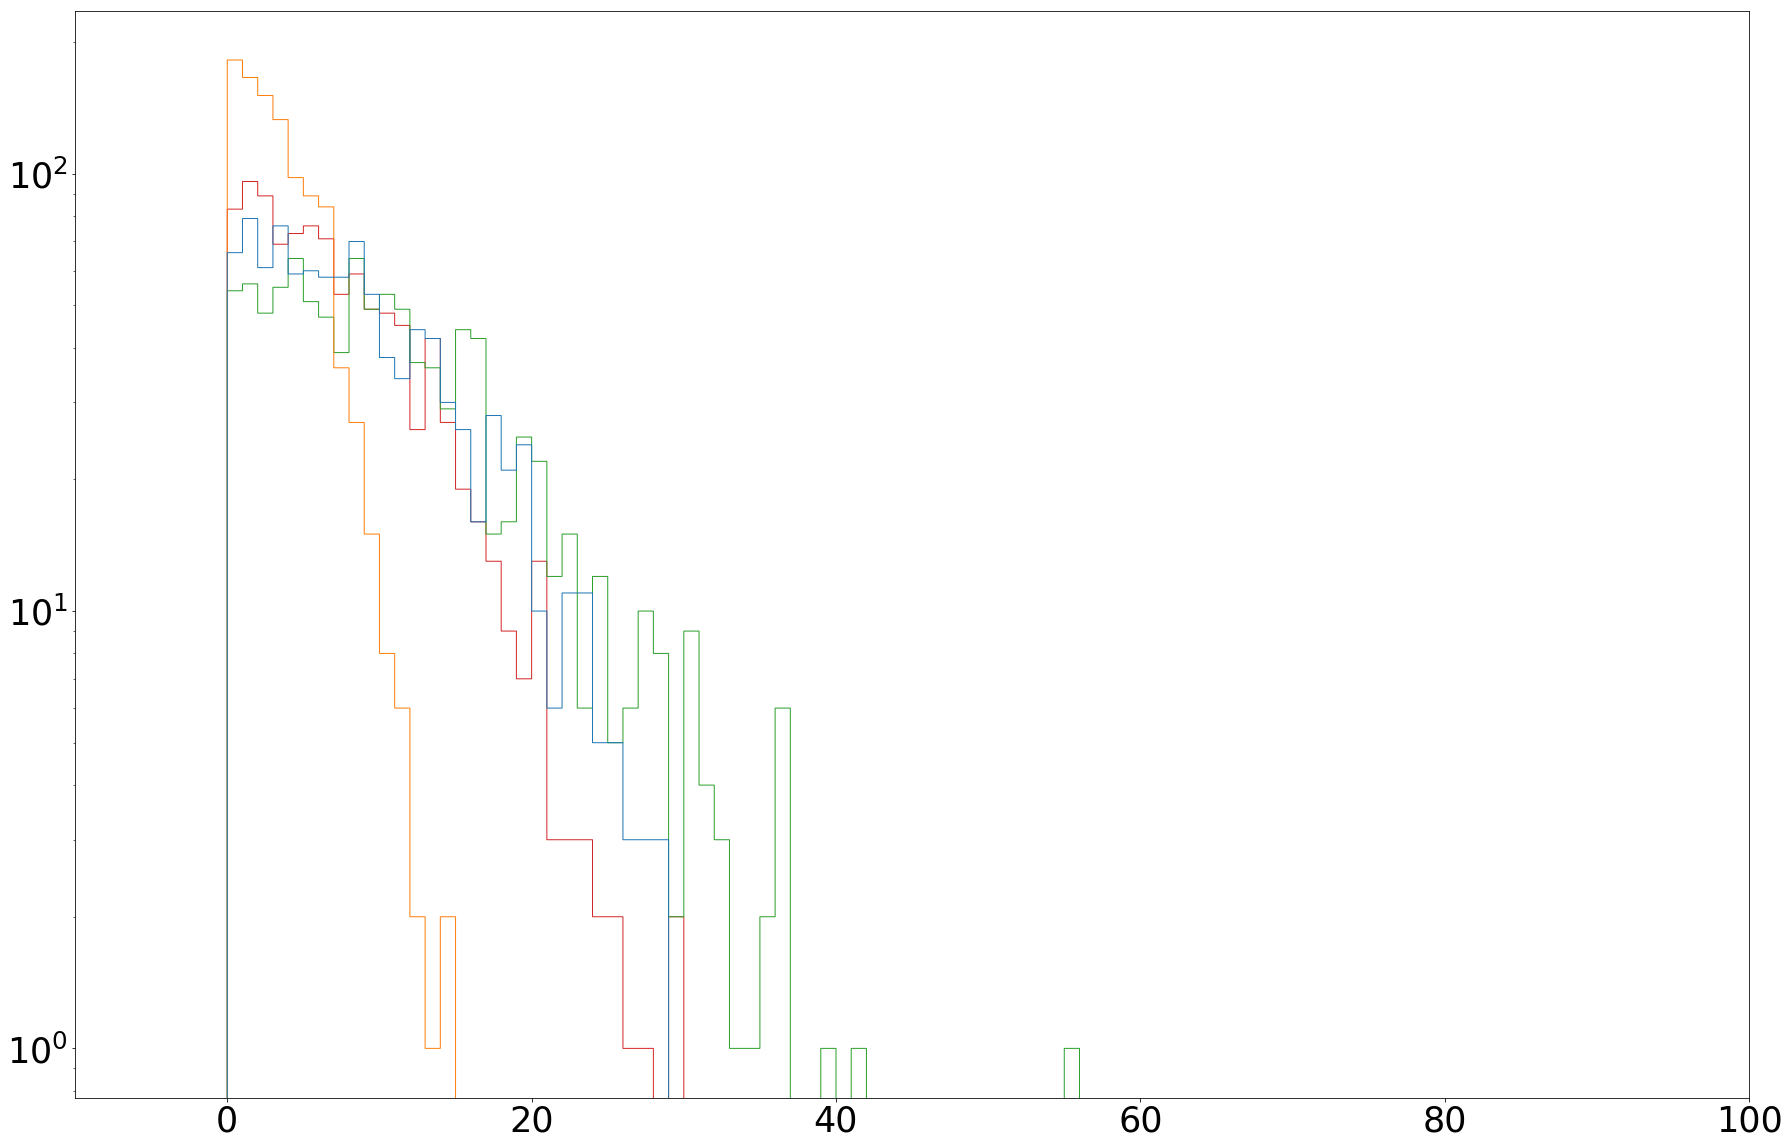

In [3]:
plt.figure(figsize=(30,20))
#plt.hist(np.sqrt(np.sum(np.power(a[:,0:4],2.),axis=1)),bins=1000,range=[0,1000],histtype='step')
plt.hist(np.sqrt(np.power(amps[:,0:4],2.)),bins=1500,range=[0,1500],histtype='step')
plt.tick_params(labelsize=fs)
plt.yscale('log')
plt.tick_params(labelsize=fs,axis='both',which='both')
plt.xlim((-10,100))
plt.show()

In [4]:
amps2=np.zeros((len(data),4))+100

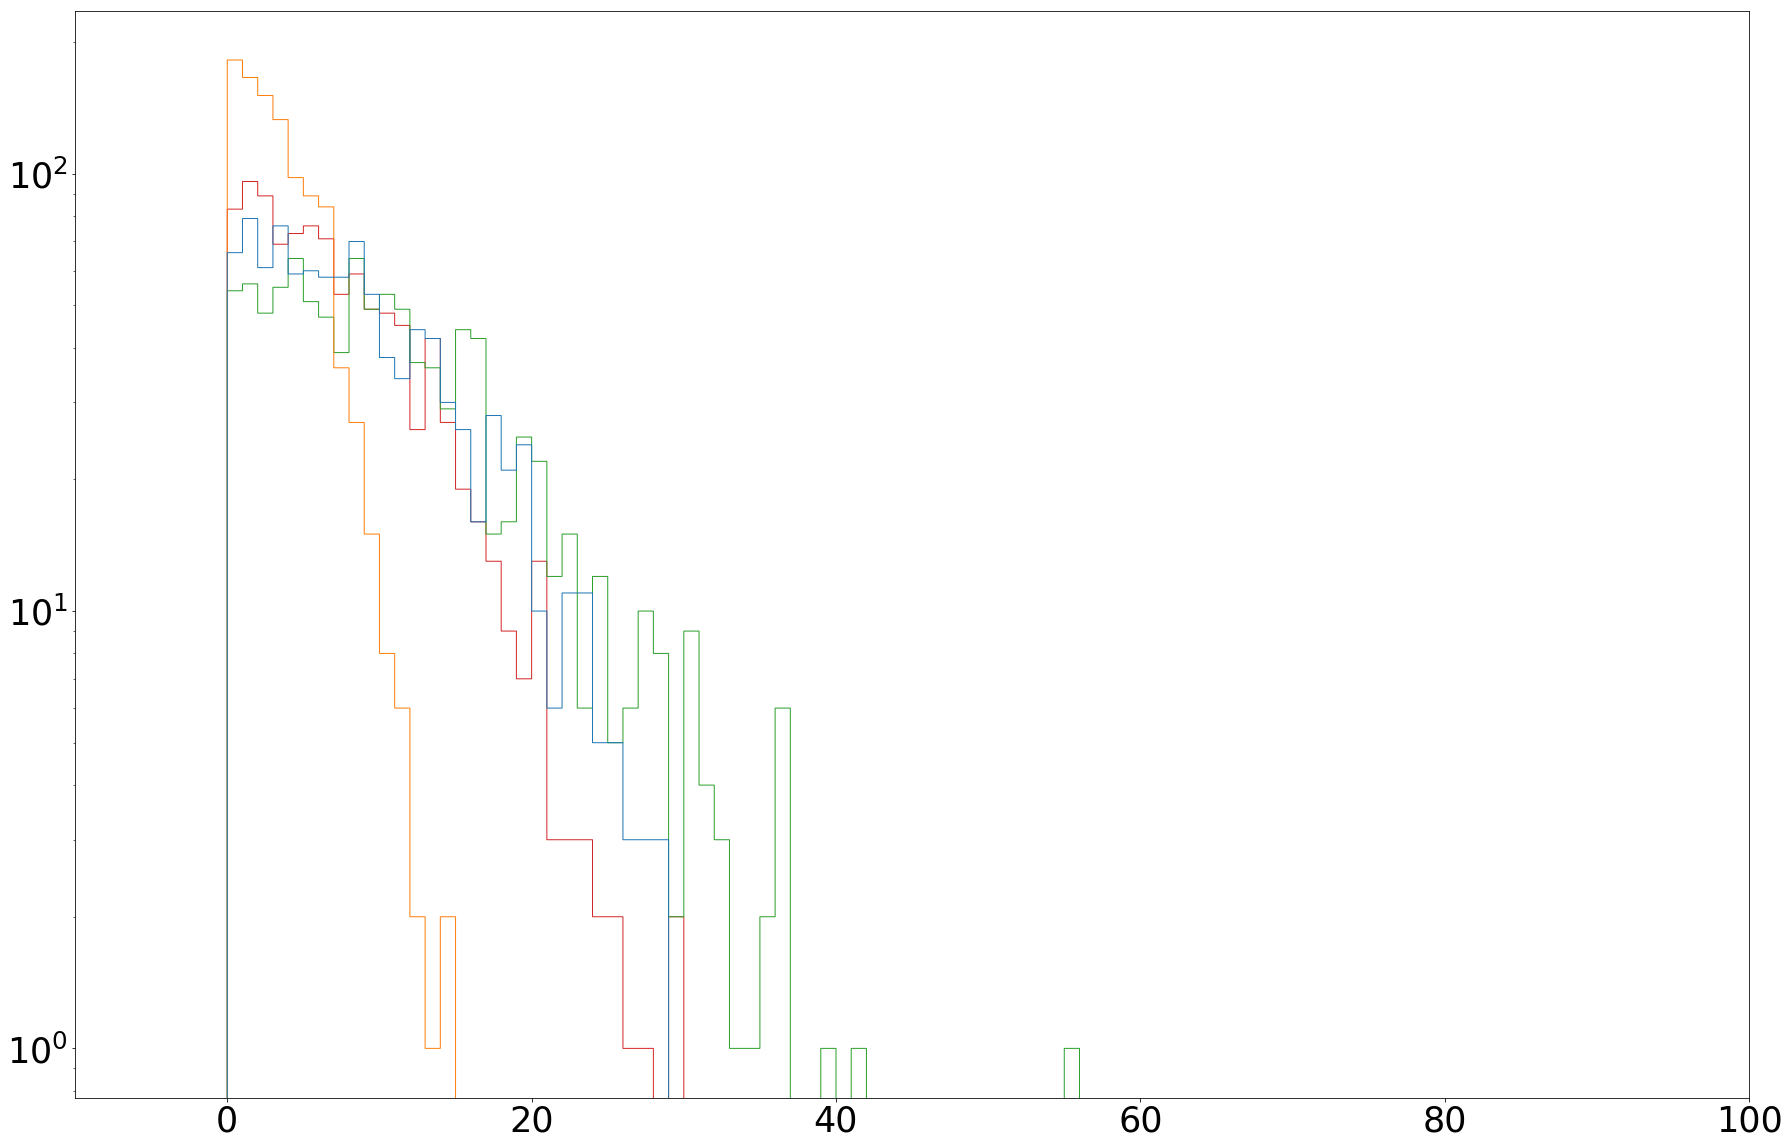

In [5]:
wo.osc_removal(data,amps2)
plt.figure(figsize=(30,20))
#plt.hist(np.sqrt(np.sum(np.power(a[:,0:4],2.),axis=1)),bins=1000,range=[0,1000],histtype='step')
plt.hist(np.sqrt(np.power(amps2[:,0:4],2.)),bins=1500,range=[0,1500],histtype='step')
plt.tick_params(labelsize=fs)
plt.yscale('log')
plt.tick_params(labelsize=fs,axis='both',which='both')
plt.xlim((-10,100))
plt.show()

In [6]:
print(amps2[1,:],'\n',amps[1,:])

[-6.0080707  -6.74973875 -7.85124247 11.92703556] 
 [-6.0080707  -6.74973875 -7.85124247 11.92703556]
